Content-based recommender is the recommending system to rely on the similarity of items when it recommends items to users. For example, when a user likes a specific movie, the system finds and recommends the items which have similar features to the movie the user likes.

In [1]:
# Based on content based collaborative filtering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# get data from S3
# reference to S3
import boto3
import io

bucket='sagemaker-sangam-2021'
movie_file = 'movies.csv'

# create S3 client
s3_client = boto3.client('s3')

obj = s3_client.get_object(Bucket=bucket, Key=movie_file)

movies = pd.read_csv(io.BytesIO(obj['Body'].read()))

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.shape

(9742, 3)

In [5]:
# create a function to create a table showing the numbers of missing values for each feature
def create_missing_df(dataframe):
  
  missing_index = dataframe.columns.tolist() 
  missing = dataframe.isnull().sum().tolist()
  missing_df = pd.DataFrame({'Missing':missing}, index=missing_index)

  return missing_df

In [6]:
create_missing_df(movies)

,Missing
movieId,0
title,0
genres,0


The column title has title and year embedded ...creating two functions to split title and year

In [7]:
# the function to extract titles
def extract_title(title):

  year = title[len(title)-5:len(title)-1]

  # some movies do not have the info about year in the column title. So, we should take care of the case as well.
  if year.isnumeric():
    title_no_year = title[:len(title)-7]
    return title_no_year

  else:
    return title

In [8]:
# the function to extract years
def extract_year(title):

  year = title[len(title)-5:len(title)-1]

  # some movies do not have the info about year in the column title. So, we should take care of the case as well.
  if year.isnumeric():
    return int(year)

  else:
    return np.nan

In [9]:
movies.rename(columns={'title':'title_year'}, inplace=True) # change the column name from title to title_year
movies['title_year'] = movies['title_year'].apply(lambda x: x.strip()) # remove leading and ending whitespaces in title_year
movies['title'] = movies['title_year'].apply(extract_title) # create the column for title
movies['year'] = movies['title_year'].apply(extract_year) # create the column for year

In [10]:
create_missing_df(movies)

,Missing
movieId,0
title_year,0
genres,0
title,0
year,12


The column genres is the only feature used for this recommending system

In [13]:
r,c = movies[movies['genres']=='(no genres listed)'].shape 
print('The number of movies which do not have info about genres:',r)

The number of movies which do not have info about genres: 0


In [12]:
# since genre is the main feature, deleting all moviews which have no genre
movies = movies[~(movies['genres']=='(no genres listed)')].reset_index(drop=True)

In [14]:
# movies have multiple genre too
movies[['title','genres']].head(5)

,title,genres
0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji,Adventure|Children|Fantasy
2,Grumpier Old Men,Comedy|Romance
3,Waiting to Exhale,Comedy|Drama|Romance
4,Father of the Bride Part II,Comedy


Let's see how many times each genre appears in the data.

In [15]:
# remove '|' in the genres column
movies['genres'] = movies['genres'].str.replace('|',' ')

In [16]:
# count the number of occurences for each genre in the data set
counts = dict()

for i in movies.index:
  for g in movies.loc[i,'genres'].split(' '):
    if g not in counts:
      counts[g] = 1
    else:
      counts[g] = counts[g] + 1

Text(0, 0.5, 'Counts')

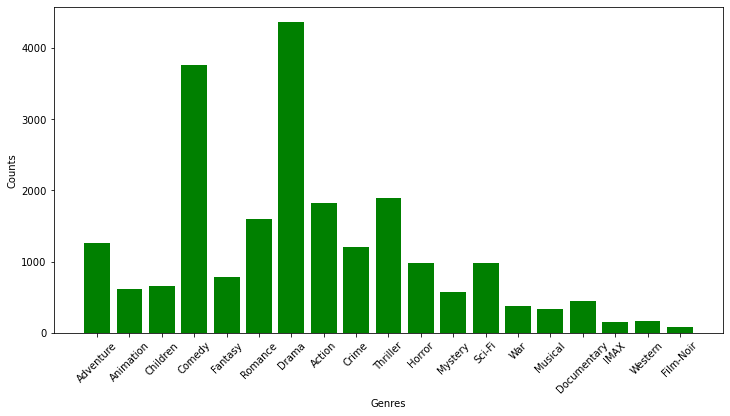

In [17]:
plt.figure(figsize=(12,6))
plt.bar(list(counts.keys()), counts.values(), color='g')
plt.xticks(rotation=45)
plt.xlabel('Genres')
plt.ylabel('Counts')

Term Frequency and Inverse Document Frequency (tf-idf)

The TfidVectorizer() class from the sklearn.feature_extraction.text library helps us to calculate the tf-idf scores for each genre in each movie.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

movies['genres'] = movies['genres'].str.replace('Sci-Fi','SciFi')
movies['genres'] = movies['genres'].str.replace('Film-Noir','Noir')

tfidf_vector = TfidfVectorizer(stop_words='english') # create an object for TfidfVectorizer
tfidf_matrix = tfidf_vector.fit_transform(movies['genres']) # apply the object to the genres column

In [19]:
print(list(enumerate(tfidf_vector.get_feature_names())))

[(0, 'action'), (1, 'adventure'), (2, 'animation'), (3, 'children'), (4, 'comedy'), (5, 'crime'), (6, 'documentary'), (7, 'drama'), (8, 'fantasy'), (9, 'horror'), (10, 'imax'), (11, 'musical'), (12, 'mystery'), (13, 'noir'), (14, 'romance'), (15, 'scifi'), (16, 'thriller'), (17, 'war'), (18, 'western')]


Let's see the examples of the vectorization for the first 5 movies.

In [20]:
print(tfidf_matrix[:5])

  (0, 8)	0.48301747178653426
  (0, 4)	0.26738777563975086
  (0, 3)	0.5048957307474672
  (0, 2)	0.5162876752057701
  (0, 1)	0.41680359510322523
  (1, 8)	0.5936766667075072
  (1, 3)	0.6205672299106341
  (1, 1)	0.5122932056626417
  (2, 14)	0.8211549883098352
  (2, 4)	0.5707052524498741
  (3, 7)	0.46621627821471856
  (3, 14)	0.7264518207332316
  (3, 4)	0.5048862585582906
  (4, 4)	1.0


The first argument in the index above is the same as the index in the dataframe movies (Not movieId), and the second argument represents the index number of genres. The numbers in the second argument correspond to the index number in the previous code output. [(0, 'action'), (1, 'adventure'), (3, 'children'),...] For example, (0,8) = 0.4830 means that movie index = 0 (Toy Story), genre index = 8 ('fantasy'), and the tf-idf score = 0.4830. The tf-idf score of comedy for Toy Story is (0,4)=0.2674. As mentioned earlier, the comedy has lower score than fantasy because it is very common genre in the whole data set, and is considered less important in defining the genre of the movie.

In [21]:
tfidf_matrix.shape

(9708, 19)

In [22]:
# the first row vector of tfidf_matrix (Toy Story)
tfidf_matrix.todense()[0]

matrix([[0.        , 0.4168036 , 0.51628768, 0.50489573, 0.26738778,
         0.        , 0.        , 0.        , 0.48301747, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ]])

Next, let's caculate the similarity between two movies using the tf-idf matrix. The cosine similarity is used to calculate the similarity, and linear_kernel() class is used to calculate this.

In [23]:
from sklearn.metrics.pairwise import linear_kernel

In [24]:
sim_matrix = linear_kernel(tfidf_matrix,tfidf_matrix) # create the cosine similarity matrix
print(sim_matrix)

[[1.         0.8136036  0.15259961 ... 0.         0.42114166 0.26738778]
 [0.8136036  1.         0.         ... 0.         0.         0.        ]
 [0.15259961 0.         1.         ... 0.         0.         0.57070525]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.42114166 0.         0.         ... 0.         1.         0.        ]
 [0.26738778 0.         0.57070525 ... 0.         0.         1.        ]]


sim_matrix$_{ij}$ is the similarity score between movie $i$ and movie $j$.Therefore, the diagonal elements in the matrix represent the similarity scores of a movie with itself, and therefore, the value should be 1. By the definition of the matrix, sim_matrix$_{ij}$ = sim_matrix$_{ji}$

the Recommendation Engine

In [32]:
# the function to convert from index to title_year
def get_title_year_from_index(index):

  return movies[movies.index == index]['title_year'].values[0]

# the function to convert from title to index
def get_index_from_title(title):

  return movies[movies.title == title].index.values[0]

# a function to convert index to title
def get_title_from_index(index):

  return movies[movies.index == index]['title'].values[0]

Apply Levenshtein Distance for 'Did you mean?' Algorithm

We often misspell titles of movies when we use movie recommending system. When we use Google to search movies, if we misspell the title of the movie, we see that Google asks us, 'Did you mean...?'. Let's create the similar function to correct misspelled title in order to make the system work easily. I apply Levenshtein Distance in order to implement 'Did you mean...?' algorithm. fuzzywuzzy library in Python provides fuzz class for the Levenshtein Distance.

In [27]:
!pip install fuzzywuzzy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [29]:
!pip install python-Levenshtein

     |████████████████████████████████| 50 kB 8.1 MB/s  eta 0:00:01
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp36-cp36m-linux_x86_64.whl size=155938 sha256=e88aa457701c92b9c0c86587e145589f41436e5afa44c8e5e82a2084926a2d3a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/4a/a4/bf/d761b0899395c75fa76d003d607b3869ee47f5035b8afc30a2
Successfully built python-Levenshtein
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [30]:
from fuzzywuzzy import fuzz

In [31]:
# create a function to find the closest title
def matching_score(a,b):

  return fuzz.ratio(a,b)

fuzz.ratio(a,b) calculates the Levenshtein Distance between a and b, and return the score for the distance. If the two words, a and b, are exactly the same, the score becomes 100. As the distance between the words increases, the score falls.

In [34]:
# the function to return the most similar title to the words a user types
# The function find_closest_title() is supposed to return the most similar title to the words a user types. 
# Without this, the recommending system only works when the movie title a user types is exactly the same 
# as the movie title the system has

def find_closest_title(title):

  leven_scores = list(enumerate(movies['title'].apply(matching_score, b=title)))
  sorted_leven_scores = sorted(leven_scores, key=lambda x: x[1], reverse=True)
  closest_title = get_title_from_index(sorted_leven_scores[0][0])
  distance_score = sorted_leven_scores[0][1]

  return closest_title, distance_score

In [35]:
# the main recommender
def contents_based_recommender(movie_user_likes, how_many):

  closest_title, distance_score = find_closest_title(movie_user_likes)

  if distance_score == 100:

    movie_index = get_index_from_title(closest_title)
    movie_list = list(enumerate(sim_matrix[int(movie_index)]))
    similar_movies = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True))) # remove the typed movie itself

    print('Here\'s the list of movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')

    for i,s in similar_movies[:how_many]: 
      print(get_title_year_from_index(i))
    

  else:
    print('Did you mean '+'\033[1m'+str(closest_title)+'\033[0m'+'?','\n')

    movie_index = get_index_from_title(closest_title)
    movie_list = list(enumerate(sim_matrix[int(movie_index)]))
    similar_movies = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True)))

    print('Here\'s the list of movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')

    for i,s in similar_movies[:how_many]:
      print(get_title_year_from_index(i))

In [38]:
# testing the system
contents_based_recommender('Monsters, Inc.', 5)

Here's the list of movies similar to Monsters, Inc..

Toy Story (1995)
Antz (1998)
Toy Story 2 (1999)
Adventures of Rocky and Bullwinkle, The (2000)
Emperor's New Groove, The (2000)


In [37]:
# testing with incorrect name

contents_based_recommender('Monster Incorporation.', 5)

Did you mean Monsters, Inc.? 

Here's the list of movies similar to Monsters, Inc..

Toy Story (1995)
Antz (1998)
Toy Story 2 (1999)
Adventures of Rocky and Bullwinkle, The (2000)
Emperor's New Groove, The (2000)


In [40]:
# testing the system
contents_based_recommender('Grumpier Old Men', 5)

Here's the list of movies similar to Grumpier Old Men.

Sabrina (1995)
Clueless (1995)
Two if by Sea (1996)
French Twist (Gazon maudit) (1995)
If Lucy Fell (1996)


In [41]:
# testing the system
contents_based_recommender('Grumpr Ol Men', 5)

Did you mean Grumpier Old Men? 

Here's the list of movies similar to Grumpier Old Men.

Sabrina (1995)
Clueless (1995)
Two if by Sea (1996)
French Twist (Gazon maudit) (1995)
If Lucy Fell (1996)
